In [2]:
# !pip install pretty_midi

In [ ]:
  # from google.colab import drive
  # drive.mount('/content/drive')

In [ ]:
# !ls "/content/drive/My Drive/_data"

ls: cannot access '/content/drive/My Drive/_data': No such file or directory


In [8]:
# !mkdir _data
# !unzip "_data.zip" -d "_data"

In [9]:
!ls

_data  _data.zip  sample_data


In [12]:
import random
import os
import pretty_midi
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# torch stuff
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset

# we use GPU if available, otherwise CPU
device_to_use = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_to_use)
print(f"Using {device_to_use} device")


Using cuda:0 device


In [13]:
DATA_PATH = "_data"

def get_samples(style="J", train=True, n=100, random=False):
    """Return the preprocessed samples

    Parameters
    ----------
    style : str, optional
        Style of the music, one of {"J", "C"} (for "Jazz" and "Classic"), by default "J"
    train : bool, optional
        Whether to choose the train or validation set, by default True
    n : int, optional
        Number of samples which will be returned, by default 100
    random : bool, optional
        Whether to randomize the samples or not, by default False

    Returns
    -------
    List (of Numpy arrays)
        List of samples
    """
    if style == "J":
        folder = "JC_J"
        prefix = "jazz"
    elif style == "C":
        folder = "JC_C"
        prefix = "classic"
    else:
        raise Exception("'style' must be one of {'J', 'C'}")
    # folder = ""
    # prefix = "jazz"
    train_or_valid = "train" if train else "test"

    nb_samples = sum(
        1
        for item in os.listdir(f"{DATA_PATH}/{folder}/{train_or_valid}")
        if os.path.isfile(os.path.join(f"{DATA_PATH}/{folder}/{train_or_valid}", item))
    )
    # nb_samples = 4000
    numbers = list(range(1, nb_samples))
    if random:
        np.random.shuffle(numbers)
    numbers = numbers[:n]
    samples = []
    for i, number in enumerate(numbers):
        #{DATA_PATH}/{folder}/{train_or_valid}/
        if os.path.isfile(f"{DATA_PATH}/{folder}/{train_or_valid}/{prefix}_piano_{train_or_valid}_{number}.npy"):
            sample = np.load(
                # {DATA_PATH}/{folder}/{train_or_valid}/
                f"{DATA_PATH}/{folder}/{train_or_valid}/{prefix}_piano_{train_or_valid}_{number}.npy"
            )
            # samples.append(sample.astype(int).reshape((64 * 84, 1)))
            samples.append(sample.astype(int).reshape((1, 64 * 84)))

    # return np.column_stack(samples)
    return np.vstack(samples)

In [14]:
latent_dim = 512

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        n_features = latent_dim
        n_out = 64 * 84
        
        # self.hidden0 = nn.Sequential(
        #     nn.Linear(n_features, 256),
        #     nn.LeakyReLU(0.2)
        # )
        # self.hidden1 = nn.Sequential(            
        #     nn.Linear(256, 512),
        #     nn.LeakyReLU(0.2)
        # )
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(2048, n_out),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        # x = self.hidden2(x)
        x = self.out(x)
        return x

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        n_features = 64 * 84
        n_out = 1

        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [16]:
n = 1000
batch_size = 32
data = get_samples(style="C", n=n, random=True)
dataset = TensorDataset(torch.Tensor(data).type(torch.float), torch.Tensor(np.ones((data.shape[0], 1))).type(torch.int64))
loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=batch_size)

Discriminator data distribution (batch 0)


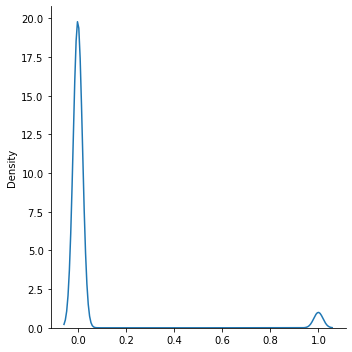

Note played simultaneously (in avg) for real data : 4.02
Epoch 0: D (0.0000 real_err, 0.0000 fake_err) G (20.4678 err) 
Time since beginning: 2.8 sec
Generated data: 
Min value: 1.3376340805851407e-35 / Max value: 1.0
Note played simultaneously (in avg) for generated data : 5.59


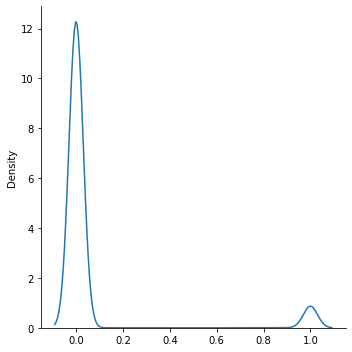

Epoch 20: D (0.0000 real_err, 0.0000 fake_err) G (89.2054 err) 
Time since beginning: 21.7 sec
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously (in avg) for generated data : 53.09


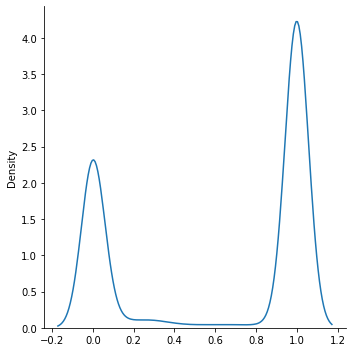

KeyboardInterrupt: ignored

In [21]:
start_time = time.time()

n_epochs = 1000

G = Generator().to(device)
D = Discriminator().to(device)

loss = nn.BCELoss()
# d_optimizer = optim.SGD(D.parameters(), lr=1e-3, momentum=0.8)
# g_optimizer = optim.SGD(G.parameters(), lr=1e-3, momentum=0.8)

d_optimizer = optim.Adam(D.parameters(), lr=1e-3)
g_optimizer = optim.Adam(G.parameters(), lr=1e-3)

n_steps_discriminator = 1
n_steps_generator = 1


fake_data_list = []

def extract(v):
    return v.data.storage().tolist()
epochs = []
d_fake_errs = []
d_real_errs = []
g_errs = []

# d_avg_notes = 0

for epoch in range(n_epochs):
    # for _ in range(20):  # train D for 20 steps
    for batch_idx, sample in enumerate(loader):


        D.zero_grad()  # could be d_optimizer.zero_grad() since the optimizer is specific to the model

        inputs, labels = sample
        N = len(inputs)
        # print(N)
        inputs_real_data, labels_real_data = inputs.to(device), labels.to(device)

        if epoch == 0 and batch_idx == 0:
            print("Discriminator data distribution (batch 0)")
            sns.displot(inputs_real_data.cpu().detach().numpy().flatten(), kind="kde")
            plt.show()
            print(f"Note played simultaneously (in avg) for real data : {inputs_real_data.cpu().detach().numpy().flatten().sum() / ( N * 64):.2f}")

        for _ in range(n_steps_discriminator):
          d_real_decision = D(inputs_real_data)
          d_real_error = loss(
              d_real_decision, Variable(torch.ones([N, 1])).to(device)
          )  # ones = true
          d_real_error.backward()  # compute/store gradients, but don't change params

          # train D on fake data
          d_gen_seed = Variable(torch.FloatTensor(torch.randn(N, latent_dim))).to(
              device
          )
          d_fake_data = G(d_gen_seed).detach()  # detach to avoid training G on these labels
          d_fake_decision = D(d_fake_data)
          d_fake_error = loss(
              d_fake_decision, Variable(torch.zeros([N, 1]).to(device))
          )  # zeros = fake
          d_fake_error.backward()
          d_optimizer.step()  # Only optimizes D's parameters; changes based on stored gradients from backward()

          dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]

        for _ in range(n_steps_generator):
            G.zero_grad()

            g_gen_seed = Variable(torch.FloatTensor(torch.randn(N, latent_dim))).to(
                device
            )
            g_fake_data = G(g_gen_seed)
            dg_fake_decision = D(g_fake_data)
            g_error = loss(
                dg_fake_decision, Variable(torch.ones([N, 1]).to(device))
            )  # Train G to pretend it's genuine

            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters

            ge = extract(g_error)[0]

    epochs.append(epoch)
    d_fake_errs.append(dfe)
    d_real_errs.append(dre)
    g_errs.append(ge)

    if epoch % 20 == 0:
        print(
            "Epoch %s: D (%1.4f real_err, %1.4f fake_err) G (%1.4f err) "
            % (epoch, dre, dfe, ge)
        )
        print(f"Time since beginning: {time.time() - start_time:.1f} sec")
        numpy_fake_data = g_fake_data.cpu().detach().numpy()
        print("Generated data:", f"\nMin value: {numpy_fake_data.min()} / Max value: {numpy_fake_data.max()}")
        print(f"Note played simultaneously (in avg) for generated data : {numpy_fake_data.sum() / (N * 64):.2f}")
        sns.displot(numpy_fake_data.flatten(), kind="kde")
        plt.show()
        fake_data_list.append((epoch, numpy_fake_data[0, :], numpy_fake_data[1, :], numpy_fake_data[-1, :]))

print(
    "Epoch %s: D (%1.4f real_err, %1.4f fake_err) G (%1.4f err) "
    % (epoch, dre, dfe, ge)
)

In [ ]:
s = time.time()

TODO:
- augmenter epochs
- modifier structure D/G
- augmenter les steps de G
- batch size ?
- plus de données
- metrics fin de convergence
- pas tjrs get le data[0], en choisir qq uns
- graph des 

Text(0, 0.5, 'error')

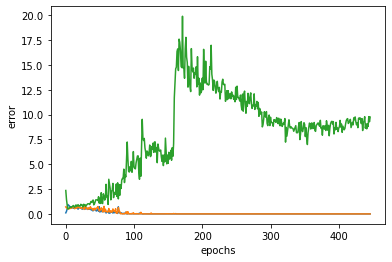

In [ ]:
plt.plot(epochs, d_fake_errs)
# plt.legend("sympa", loc='lower center')
plt.plot(epochs, d_real_errs)
plt.plot(epochs, g_errs)
plt.xlabel("epochs")
plt.ylabel("error")

In [ ]:
def raw_to_midi(array, name, precision=1e-2):
    pm = pretty_midi.PrettyMIDI()
    # Create an Instrument instance
    program = pretty_midi.instrument_name_to_program('Cello')
    piano = pretty_midi.Instrument(program=program)
    # array = tensor.cpu().detach().numpy()
    # def _round(x):
    #     if x < precision:
    #         return 0
    #     elif x > 1 - precision:
    #         return 1
    #     return x
    array = np.array(list(map(lambda x: 0 if x < precision else 1, array)))
    array = array.reshape((64, 84))
    for time_idx in range(64):
        for pitch_idx in range(84):
            if array[time_idx, pitch_idx] == 1:
                note = pretty_midi.Note(
                velocity=100, pitch=25 + pitch_idx, start=1 / 16 * time_idx, end=1 / 16 * (time_idx + 1))
                # Add it to our instrument
                piano.notes.append(note)
    pm.instruments.append(piano)
    # Write out the MIDI data
    pm.write(f'midi_results/{name}.mid')
    
        



In [ ]:
a = g_fake_data[0].cpu().detach().numpy()
raw_to_midi(a, "test", precision=1e-1)

In [ ]:
a

array([0.0025025 , 0.00185667, 0.02190318, ..., 0.00295474, 0.00201577,
       0.00181699], dtype=float32)

In [ ]:
raw_to_midi(data[0], "normal", precision=1e-1)

In [ ]:
# f_to_midi = [980, 600, 560, 500, 440, 460]
# f_to_midi = [40, 60, 240, 260]
f_to_midi = list(range(0, 460, 20))
# f_to_midi = [580]
indices = []
for idx in f_to_midi:
  indices.append([t[0] for t in fake_data_list].index(idx))

for i, idx in enumerate(indices):
  raw_to_midi(fake_data_list[idx][1], f"02_17_{f_to_midi[i]}")


In [ ]:
f_to_midi = list(range(0, 460, 20))
indices = []
for idx in f_to_midi:
  indices.append([t[0] for t in fake_data_list].index(idx))
for i, idx in enumerate(indices):
  raw_to_midi(fake_data_list[idx][1], f"classic/more_02_16_1_{f_to_midi[i]}")
  raw_to_midi(fake_data_list[idx][2], f"classic/more_02_16_2_{f_to_midi[i]}")
  raw_to_midi(fake_data_list[idx][3], f"classic/more_02_16_3_{f_to_midi[i]}")

In [ ]:
numpy_fake_data

array([[6.69982906e-12, 3.02907525e-11, 1.74374022e-11, ...,
        6.13943748e-12, 3.98724560e-11, 1.15015853e-12],
       [3.79989859e-11, 1.10656206e-10, 7.89946858e-11, ...,
        2.00418258e-11, 1.62320463e-10, 4.71105186e-12],
       [1.08914206e-11, 4.33525230e-11, 2.20033713e-11, ...,
        9.95191863e-12, 6.54912652e-11, 1.25300616e-12],
       ...,
       [1.03405062e-11, 4.17994458e-11, 3.15074355e-11, ...,
        1.04251859e-11, 7.19320645e-11, 1.49803650e-12],
       [2.79842989e-11, 1.10660849e-10, 8.36410385e-11, ...,
        3.09567198e-11, 1.76549414e-10, 4.97668790e-12],
       [1.67047712e-11, 7.16406934e-11, 6.03870287e-11, ...,
        1.74169585e-11, 1.04295267e-10, 2.91535524e-12]], dtype=float32)

In [ ]:
for tuple in fake_data_list[8:]:
    raw_to_midi(tuple[1], f"nice_10steps_{tuple[0]}")

In [ ]:
raw_to_midi(fake_data_list[-1][1], f"5000")

In [ ]:
fake_data_list

[(0,
  array([0.4944722 , 0.48824844, 0.5040509 , ..., 0.4672277 , 0.50416726,
         0.50914097], dtype=float32)),
 (20,
  array([4.2990767e-04, 3.0212823e-04, 1.6526238e-03, ..., 7.9703328e-05,
         1.1255940e-03, 8.9708244e-04], dtype=float32)),
 (40,
  array([0.00567092, 0.00258316, 0.01168862, ..., 0.00304571, 0.00492434,
         0.00556258], dtype=float32)),
 (60,
  array([0.00121755, 0.00027669, 0.01548108, ..., 0.00043324, 0.00051334,
         0.00030826], dtype=float32)),
 (80,
  array([1.4379176e-03, 4.3764905e-04, 4.8852971e-01, ..., 6.6985749e-04,
         4.7460065e-04, 3.3473939e-04], dtype=float32)),
 (100,
  array([0.00073991, 0.0003188 , 0.00693077, ..., 0.0008195 , 0.00040314,
         0.00026975], dtype=float32)),
 (120,
  array([2.4394337e-03, 6.9980620e-04, 9.4728804e-01, ..., 4.0026554e-03,
         1.0089302e-03, 5.6759396e-04], dtype=float32)),
 (140,
  array([0.00043589, 0.00013761, 0.00021011, ..., 0.00055069, 0.0001505 ,
         0.00015804], dtype=flo

In [ ]:
np.median(g_fake_data[0].cpu().detach().numpy())

0.008360177

In [ ]:
print(f"Note played simultaneously (in avg) for real data : {data[0].sum() / 64}")
print(f"Note played simultaneously (in avg) for fake data : {g_fake_data[0].cpu().detach().numpy().sum() / 64}")
print(f"Note played simultaneously (in avg) for fake data : {fake_data_list[idx][1].sum() / 64}")

Note played simultaneously (in avg) for real data : 4.9375
Note played simultaneously (in avg) for fake data : 1.475616455078125
Note played simultaneously (in avg) for fake data : 4.571640968322754
